# Raytracing, Perturbing, and Fitting the OPD
*David Thomas and Emily Li 2019/06/27*

**Summary**: Optical path differences characterize the state of the LSST optical system. In this notebook we learn (i) how to simulate OPD images with batoid, (ii) how to introduce perturbations into the optical system, and (iii) how to fit the OPD images.

**Table of Contents:**
- [The OPD](#The_OPD)
- [Batoid Shifts And Rotations](#Batoid_Shifts_And_Rotations)
- [Batoid Surface Perturbations](#Batoid_Surface_Perturbations)
- [Fitting The OPD](#Fitting_The_OPD)

### The OPD
Physical changes to the LSST optical system change the paths photons take from their source (distant star) to the destination (CCDs in the focal plane). One way we can characterize the state of the optical system is by the length of the path a photon takes from a given position in the entrance pupil (theoretical/abstract planar surface that spans the top of M1 and connects to its outer perimeter) to the exit pupil (theoretical/abstract spherical surface behind the focal plane - where the entrance pupil is imaged). In the context of the AOS, the optical path difference (OPD) is an image which measures the difference in path lengths between the ideal and present optical system for a lattic of 256x256 rays (it is a 256x256 image). The graphic below gives more intuition on the OPD. The sphere on the left in this diagram corresponds to the entrance pupil, the sphere on the right corresponds to the exit pupil, and the OPD captures the difference between the wavefront and the exit pupil. The geometry is a bit different for LSST, but the idea is the same.

<img src='opd.png'>



We start by importing the python modules we will need.

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os
import batoid
import yaml
from batoid.utils import fieldToDirCos

Below is a batoid code snippet that computes the OPD for LSST. We are going to walk through it in the next few cells. First, we load the LSST optical system.

In [55]:
LSST_g_fn = os.path.join(batoid.datadir, "LSST", "LSST_g.yaml")
config = yaml.safe_load(open(LSST_g_fn))
optic = batoid.parse.parse_optic(config['opticalSystem'])

Just for fun, let's see where this is stored on your machine.

In [4]:
print(LSST_g_fn)

/Users/user/miniconda2/envs/tflow/lib/python3.5/site-packages/batoid-0.1.0rc2-py3.5-macosx-10.7-x86_64.egg/batoid/data/LSST/LSST_g.yaml


Let's see what is in it. Note that having an '!' exclamation point at the beginning of the line runs it as a bash command, like in your terminal.

Note: you will need to replace the path below with the path on your machine.

In [5]:
! cat /Users/user/miniconda2/envs/tflow/lib/python3.5/site-packages/batoid-0.1.0rc2-py3.5-macosx-10.7-x86_64.egg/batoid/data/LSST/LSST_g_500.yaml

opticalSystem:
  type: CompoundOptic
  name: LSST
  inMedium: 1.0
  medium: 1.0
  dist: 15.0  # distance from global vertex to use to start tracing rays
  sphereRadius: 5.0  # reference sphere radius to use for wavefront calculation
  pupilSize: 8.36  # Pupil fits inside a square with this side length
  pupilObscuration: 0.612  # Fractional pupil central obscuration
  items:
    -
      type: Mirror
      name: M1
      surface:
        type: Asphere
        R: 19.835
        conic: -1.215
        coefs: [-0.0, -1.381e-9]
      obscuration:
        type: ClearAnnulus
        outer: 4.18
        inner: 2.558
    -
      type: Mirror
      name: M2
      surface:
        type: Asphere
        R: 6.788
        conic: -0.222
        coefs: [-0.0, 1.274e-5, 9.68e-7]
      obscuration:
        type: ClearAnnulus
        outer: 1.71
        inner: 0.9
      coordSys:
        z: 6.1562006
    -
      type: Mirror
      name: M3
      surface:
        type: Asphere
        R: 8.3445
        con

**Problem 1:** The mirrors are aspheric. What does that mean? Why are they aspheric? Hint: [read this](https://www.zygo.com/?/opt/components/aspheres/aspheres.htm).

Ok. Next let's choose the ra, dec of the hypothetical source. The telescope boresight, where it is pointing is (ra=0, dec=0) in batoid. The LSST focal plane spans a radius of roughly +-1.75 degrees (note it is made up of square CCDs, so it is not a perfect circle). Let's start with a monochromatic source at (ra=0, dec=0) with 500nm wavelength.

In [6]:
theta_x = 0
theta_y = 0
wavelength = 500e-9

Let's convert the position to [direction cosines](https://en.wikipedia.org/wiki/Direction_cosine). We will also set nx to the size of the grid we want (in this case, 256 x 256) and the flux (weight per photon) to 1.

In [7]:
dirCos = fieldToDirCos(theta_x, theta_y, projection='zemax')
nx = 256 # for 256 x 256 grid
flux = 1.0

Then we can make a set of rays which we will propagate through the optics in coming cells. Let's check out what arguments this function will need by using help.

In [8]:
help(batoid.rayGrid)

Help on built-in function rayGrid in module batoid._batoid:

rayGrid(...) method of builtins.PyCapsule instance
    rayGrid(zdist: float, length: float, xcos: float, ycos: float, zcos: float, nside: int, wavelength: float, flux: float, medium: batoid._batoid.Medium, lattice: bool=False) -> batoid._batoid.RayVector
    
    Make a RayVector in a grid



Ok, let's create a RayVector with our parameters.

In [9]:
rays = batoid.rayGrid(
    optic.dist/dirCos[2], optic.pupilSize,
    dirCos[0], dirCos[1], -dirCos[2],
    nx, wavelength, flux, optic.inMedium)

Now let's inspect this ray a bit.

In [10]:
print(len(rays))
print(nx ** 2)

65536
65536


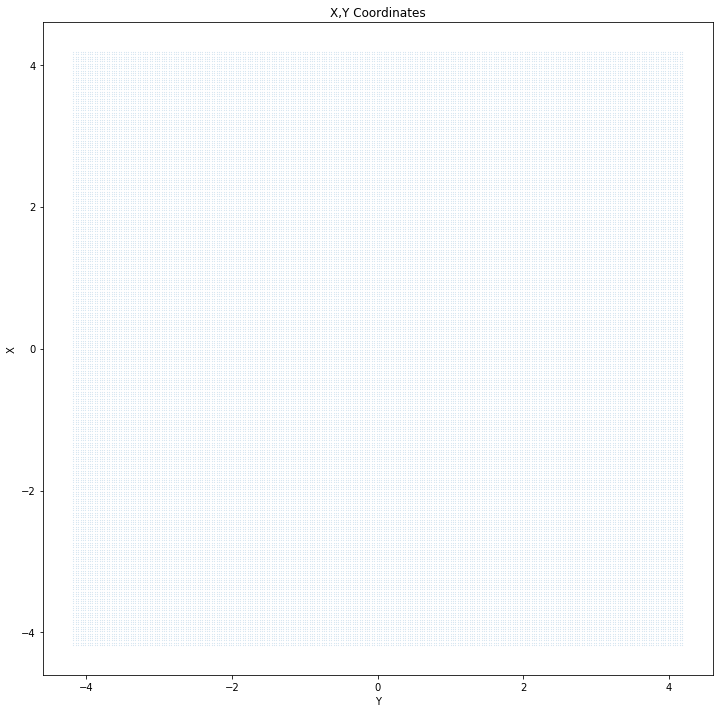

In [11]:
plt.figure(figsize=(12,12)) # figsize is in inches
plt.title('X,Y Coordinates')
plt.ylabel('X') # note coordinates are switched because we are plotting a matrix.
plt.xlabel('Y')
plt.scatter(rays.x, rays.y, s=0.004)

In [12]:
print(min(rays.x), max(rays.x))

-4.18 4.18


**Problem 2:** Do you have any idea where 4.18 comes from? Hint: the units are in meters. Further hint: the LSST primary mirror diameter is ~8.36m.

Above we plotted the X,Y position, but how far up do these rays start?

In [13]:
print('Ray starting point: ', np.mean(rays.z))
print('M1 z position: ', optic.itemDict['LSST.M1'].coordSys.origin[2])
print('M2 z position: ', optic.itemDict['LSST.M2'].coordSys.origin[2])
print('M3 z position: ', optic.itemDict['LSST.M3'].coordSys.origin[2])

Ray starting point:  15.0
M1 z position:  0.0
M2 z position:  6.1562006
M3 z position:  -0.2338


The rays all start with z=15m. This is somewhat arbitrary. We just want something that is above the rest of the optical system. Now let's start raytracing.

In [14]:
cridx = (nx//2)*nx+nx//2

This is a trick to find the index of the ray in the center of the grid. This ray serves as an important reference point when we calculate the OPD. Next we trace the rays to the detector. 

In [15]:
optic.traceInPlace(rays, outCoordSys=batoid.globalCoordSys)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


What does "in place" mean? It means that instead of returning a new set of arrays we manipulate the rays we have. We can confirm they are different by checking the new mean z position.

In [16]:
print(np.mean(rays.z), np.min(rays.z), np.max(rays.z))

4.43056865143 4.43056865143 4.43056865143


Great, since the focal plane is flat all the rays have the same z-position. If we just wanted to make an image, we would be done now. But since we want to compute the OPD, we must continue propagating the rays to the exit pupil. To do this we translate the coordinate system and define the exit pupil sphere (which for LSST is behind the focal plane). 

In [17]:
sphereRadius = optic.sphereRadius
spherePoint = rays[cridx].r
radius = np.hypot(optic.sphereRadius, np.hypot(spherePoint[0], spherePoint[1]))
transform = batoid.CoordTransform(
            batoid.globalCoordSys, batoid.CoordSys(spherePoint+np.array([0,0,radius])))
transform.applyForwardInPlace(rays)
sphere = batoid.Sphere(-radius)

We now look at the difference between the distance the chief ray travelled to the distance the other rays travelled, this is the OPD. 

In [18]:
t0 = rays[cridx].t
arr = np.ma.masked_array(t0-rays.t, mask=rays.vignetted).reshape(nx, nx)

Great! Now we have the OPD. The last thing we do is make a lattice object, which in addition to the OPD array also contains the "x" and "y" points of the surface. We will plot it below.

In [19]:
primitiveVectors = np.vstack([[optic.pupilSize/nx, 0], [0, optic.pupilSize/nx]]) # basis vectors
lattice = batoid.Lattice(arr, primitiveVectors)

We are done! Time to start plotting. Let's start with the lattice.

(256, 256, 2)


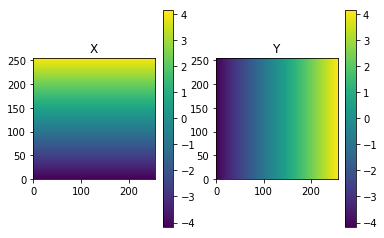

In [20]:
print(lattice.coords.shape)
X = lattice.coords[:,:,0]
Y = lattice.coords[:,:,1]

plt.figure()
plt.subplot(1,2,1)
plt.title('X')
plt.imshow(X, origin='lower')
plt.colorbar()

plt.subplot(1,2,2)
plt.title('Y')
plt.imshow(Y, origin='lower')
plt.colorbar();

Great, now let's plot the OPD we calculated.

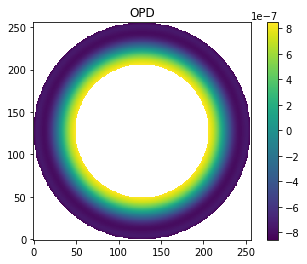

In [21]:
plt.figure()
plt.title('OPD')
plt.imshow(lattice.array, origin='lower')
plt.colorbar()

**Problem 3**: Why are the units so small? Hint: what wavelength are we using?

Ok. Below we encapsulate the OPD calculation into one method.

In [22]:
def opd(optic, theta_x, theta_y, wavelength=500e-9, nx=255, flux=1):
    projection='zemax'
    dirCos = fieldToDirCos(theta_x, theta_y, projection=projection)
    rays = batoid.rayGrid(
        optic.dist/dirCos[2], optic.pupilSize,
        dirCos[0], dirCos[1], -dirCos[2],
        nx, wavelength, flux, optic.inMedium)
    
    # chief ray index.  works if lattice=True and nx is even,
    # or if lattice=False and nx is odd
    cridx = (nx//2)*nx+nx//2
    
    optic.traceInPlace(rays, outCoordSys=batoid.globalCoordSys)
    spherePoint = rays[cridx].r
    
    # We want to place the vertex of the reference sphere one radius length away from the
    # intersection point.  So transform our rays into that coordinate system.
    radius = np.hypot(optic.sphereRadius, np.hypot(spherePoint[0], spherePoint[1]))
    transform = batoid.CoordTransform(
            batoid.globalCoordSys, batoid.CoordSys(spherePoint+np.array([0,0,radius])))
    transform.applyForwardInPlace(rays)

    sphere = batoid.Sphere(-radius)
    sphere.intersectInPlace(rays) 
    t0 = rays[cridx].t
    arr = np.ma.masked_array(t0-rays.t, mask=rays.vignetted).reshape(nx, nx)

    primitiveVectors = np.vstack([[optic.pupilSize/nx, 0], [0, optic.pupilSize/nx]])
    return batoid.Lattice(arr, primitiveVectors)

Let's see how the OPD changes with wavelength.

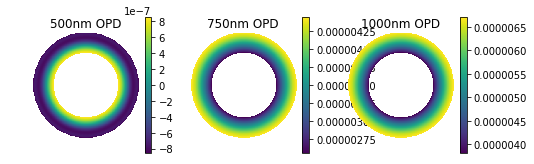

In [24]:
lattice750 = opd(optic, 0, 0, wavelength=750e-9)
lattice1000 = opd(optic, 0, 0, wavelength=1000e-9)

plt.subplot(1,3,1)
plt.title('500nm OPD')
plt.imshow(lattice.array, origin='lower')
plt.colorbar()
plt.axis('off')

plt.subplot(1,3,2)
plt.title('750nm OPD')
plt.imshow(lattice750.array, origin='lower')
plt.colorbar()
plt.axis('off')

plt.subplot(1,3,3)
plt.title('1000nm OPD')
plt.imshow(lattice1000.array, origin='lower')
plt.colorbar()
plt.axis('off')

plt.gcf().set_size_inches(8, 2.5);

**Problem 4:** Why is the OPD wavelength dependent? Hint: the LSST optical system consists of 3 mirrors and 3 lens, which of these has a wavelength dependence?

Now let's use this to see how the OPD changes with field location.

In [26]:
points = [np.deg2rad([r,r]) for r in np.linspace(0, 1.75, 4)]
lattices = [opd(optic, point[0], point[1]) for point in points]

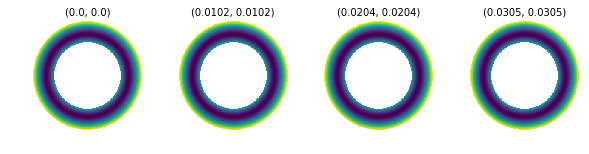

In [309]:
vmin = np.min(lattices[0].array)
vmax = np.max(lattices[0].array)
fig, axes = plt.subplots(1,4)
fig.set_size_inches(10,2)
for i,ax in enumerate(axes):
    ax.set_title('({:.3}, {:.3})'.format(points[i][0], points[i][1]), fontsize=10)
    ax.imshow(lattices[0].array, origin='lower', vmin=vmin, vmax=vmax)
    ax.axis('off')

**Problem 5:** Do you think this will continue to be the case once we introduce aberrations into the system?

### Batoid Shifts And Rotations

Next we are going to start manipulating the optical system. Let's start by seeing what methods the optic object has.

In [27]:
help(optic)

Help on CompoundOptic in module batoid.optic object:

class CompoundOptic(Optic)
 |  A Optic containing two or more Optics as subitems.
 |  
 |  Method resolution order:
 |      CompoundOptic
 |      Optic
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __eq__(self, other)
 |      Return self==value.
 |  
 |  __hash__(self)
 |      Return hash(self).
 |  
 |  __init__(self, items, **kwargs)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  __ne__(self, other)
 |      Return self!=value.
 |  
 |  __repr__(self)
 |      Return repr(self).
 |  
 |  draw2d(self, ax, **kwargs)
 |      Draw a 2D slice of this compound optic in the (x,z) plane.
 |      
 |      Calls draw2d recursively on each of our items, with the actual
 |      drawing taking place in Interface and (optionally) Lens instances.
 |      
 |      The kwargs are passed to the drawing commands, except for the
 |      optional keyword 'only' which restricts drawing to only instances


The two methods we will use to manipulate items in the optics are `withGloballyShiftedOptic` and `withLocallyRotatedOptic`. One of the arguments to these methods is the item in the optic. We display the items below.

In [33]:
list(optic.itemDict.keys())

['LSST.LSSTCamera.L1.L1_entrance',
 'LSST.LSSTCamera',
 'LSST.LSSTCamera.L2.L2_exit',
 'LSST.M2',
 'LSST.LSSTCamera.L2',
 'LSST.LSSTCamera.L3.L3_exit',
 'LSST.LSSTCamera.L1',
 'LSST.LSSTCamera.L3',
 'LSST.M3',
 'LSST.LSSTCamera.Filter.Filter_entrance',
 'LSST',
 'LSST.LSSTCamera.L3.L3_entrance',
 'LSST.LSSTCamera.Filter.Filter_exit',
 'LSST.LSSTCamera.L2.L2_entrance',
 'LSST.LSSTCamera.Detector',
 'LSST.LSSTCamera.L1.L1_exit',
 'LSST.LSSTCamera.Filter',
 'LSST.M1']

For shifts we need to supply a three dimension shift vector, for example [1,0,0] would be a shift in the x-axis. For rotations, we need to supply a three dimensional rotation matrix. Fortunately batoid has helper functions that do the latter. The naming convention is such that RotX(th) means rotate th degrees around the x-axis.

In [36]:
field_x = 5
theta_x = np.deg2rad(field_x)
batoid.RotX(theta_x)

array([[ 1.        ,  0.        ,  0.        ],
       [ 0.        ,  0.9961947 , -0.08715574],
       [ 0.        ,  0.08715574,  0.9961947 ]])

Likewise,

In [38]:
field_y = 5
theta_y = np.deg2rad(field_y)
batoid.RotY(theta_y)

array([[ 0.9961947 ,  0.        ,  0.08715574],
       [ 0.        ,  1.        ,  0.        ],
       [-0.08715574,  0.        ,  0.9961947 ]])

and

In [39]:
field_z = 5
theta_z = np.deg2rad(field_z)
batoid.RotZ(theta_z)

array([[ 0.9961947 , -0.08715574,  0.        ],
       [ 0.08715574,  0.9961947 ,  0.        ],
       [ 0.        ,  0.        ,  1.        ]])

Ok. Let's start by rotating the primary mirror M1 5 degrees around the z-axis.

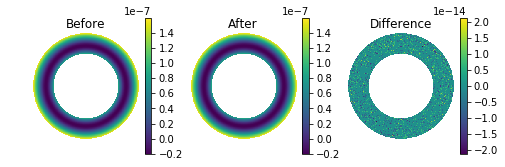

In [64]:
def plotDifference(before, after):
    plt.subplot(1,3,1)
    plt.title('Before')
    plt.imshow(before.array, origin='lower')
    plt.axis('off') # removes ticks so that plots are less cluttered
    plt.colorbar()

    plt.subplot(1,3,2)
    plt.title('After')
    plt.imshow(after.array, origin='lower')
    plt.axis('off')
    plt.colorbar()

    plt.subplot(1,3,3)
    plt.title('Difference')
    plt.imshow(after.array - before.array, origin='lower')
    plt.axis('off')
    plt.colorbar()
    
    plt.gcf().set_size_inches(8,2.5)    

theta_x, theta_y = 0,0
before = opd(optic, theta_x, theta_y)
rotAngle = 5
rot = batoid.RotZ(np.deg2rad(rotAngle))
rotOptic = optic.withLocallyRotatedOptic('LSST.M1', rot)
after = opd(rotOptic, theta_x, theta_y)

plotDifference(before, after)

** Problem 5:** Trick question: why is the difference 1e-14? Hint: Machine precision in python is ~1e-16.

** Problem 6:** Why didn't this rotation change the OPD? Hint: did we change anything?

Let's repeat that experiment with M1 rotated in the x-dimension.

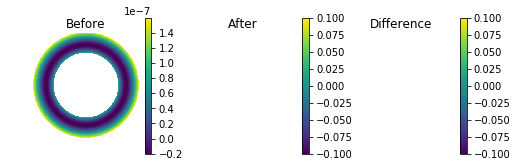

In [66]:
rotAngle = 5
rot = batoid.RotX(np.deg2rad(rotAngle))
rotOptic = optic.withLocallyRotatedOptic('LSST.M1', rot)
after = opd(rotOptic, theta_x, theta_y)

plotDifference(before, after)

This rotation changes the system enough so that all the photons are blocked from the detector (this is also called vignetting). Let's change the rotation angle to 1e-5 degrees.

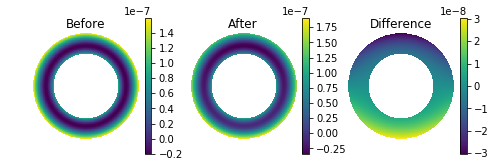

In [67]:
rotAngle = 1e-5
rot = batoid.RotX(np.deg2rad(rotAngle))
rotOptic = optic.withLocallyRotatedOptic('LSST.M1', rot)
after = opd(rotOptic, theta_x, theta_y)

plotDifference(before, after)

This matches our intuition. We tilt the primary mirror and we see tilt in the OPD. Let's make things a little more interesting. Let's also tilt M2 5e-5 degrees in the y-direction.

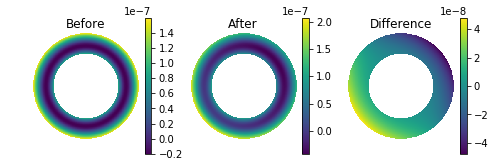

In [69]:
rotAngle1 = 1e-5
rotAngle2 = 5e-5
rot1 = batoid.RotX(np.deg2rad(rotAngle1))
rot2 = batoid.RotY(np.deg2rad(rotAngle2))
rotOptic = optic.withLocallyRotatedOptic('LSST.M1', rot1)
rotOptic = rotOptic.withLocallyRotatedOptic('LSST.M2', rot2)
after = opd(rotOptic, theta_x, theta_y)

plotDifference(before, after)

Great, now let's try a few spatial tanslations. Note: the units for batoid are always meters (for distance) or radians (for angle).

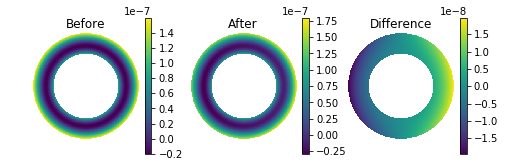

In [76]:
shiftLeft = [1e-6,0,0]
shiftOptic = optic.withGloballyShiftedOptic('LSST.M1', shiftLeft)
after = opd(shiftOptic, theta_x, theta_y)

plotDifference(before, after)

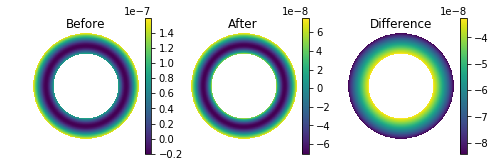

In [78]:
shiftLeft = [0,0,1e-6]
shiftOptic = optic.withGloballyShiftedOptic('LSST.M1', shiftLeft)
after = opd(shiftOptic, theta_x, theta_y)

plotDifference(before, after)

Notice how changes in z produce rotationally symmetric differences.

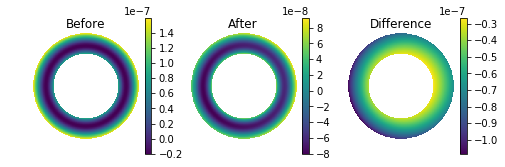

In [77]:
shift1 = [1e-6,0,0]
shift2 = [0,-1e-6,0]
shift3 = [0,0,1e-6]

shiftOptic = optic.withGloballyShiftedOptic('LSST.M1', shift1)
shiftOptic = shiftOptic.withGloballyShiftedOptic('LSST.M2', shift2)
shiftOptic = shiftOptic.withGloballyShiftedOptic('LSST.M3', shift3)

after = opd(shiftOptic, theta_x, theta_y)

plotDifference(before, after)

### Batoid Surface Perturbations

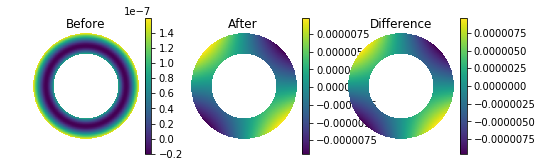

In [83]:
obscuration = 0.61

def reloadOptic():
    LSST_g_fn = os.path.join(batoid.datadir, "LSST", "LSST_g.yaml")
    config = yaml.safe_load(open(LSST_g_fn))
    optic = batoid.parse.parse_optic(config['opticalSystem'])
    return optic

perturbedOptic = reloadOptic()

#create zernike *surface*
zernikes = np.zeros(22)
zernikes[5] = 1e-6
pert = batoid.Zernike(zernikes, R_inner=obscuration)
m2surf = perturbedOptic.itemDict['LSST.M2'].surface
perturbedOptic.itemDict['LSST.M2'].surface = batoid.Sum([m2surf, pert])

after = opd(perturbedOptic, theta_x, theta_y)

plotDifference(before, after)

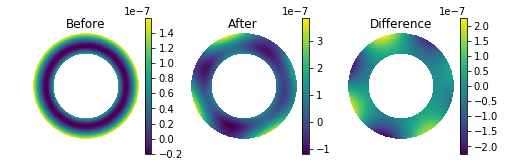

In [93]:
obscuration = 0.61

def reloadOptic():
    LSST_g_fn = os.path.join(batoid.datadir, "LSST", "LSST_g.yaml")
    config = yaml.safe_load(open(LSST_g_fn))
    optic = batoid.parse.parse_optic(config['opticalSystem'])
    return optic

perturbedOptic = reloadOptic()

#create zernike *surface*
zernikes = np.zeros(22)
zernikes[5] = 5e-9
zernikes[9] = 5e-9
zernikes[15] = -5e-9
pert = batoid.Zernike(zernikes, R_inner=obscuration)
m2surf = perturbedOptic.itemDict['LSST.M2'].surface
perturbedOptic.itemDict['LSST.M2'].surface = batoid.Sum([m2surf, pert])

after = opd(perturbedOptic, theta_x, theta_y)

plotDifference(before, after)

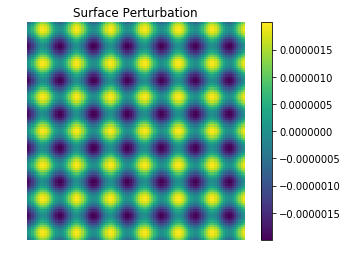

In [116]:
obscuration = 0.61

def reloadOptic():
    LSST_g_fn = os.path.join(batoid.datadir, "LSST", "LSST_g.yaml")
    config = yaml.safe_load(open(LSST_g_fn))
    optic = batoid.parse.parse_optic(config['opticalSystem'])
    return optic

perturbedOptic = reloadOptic()

#create bicubic surface
r = perturbedOptic.itemDict['LSST.M2'].outRadius
xs = np.linspace(-r,r,100)
ys = np.linspace(-r,r,100)
X,Y = np.meshgrid(xs, ys)
F = np.sin(20 * X / r ) * 1e-6 + np.cos(20 * Y / r ) * 1e-6

plt.figure()
plt.title('Surface Perturbation')
plt.imshow(F, origin='lower')
plt.colorbar()
plt.axis('off');

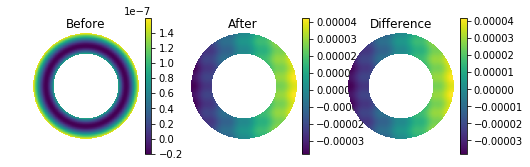

In [117]:
pert = batoid.Bicubic(xs, ys, F)
m2surf = perturbedOptic.itemDict['LSST.M2'].surface
perturbedOptic.itemDict['LSST.M2'].surface = batoid.Sum([m2surf, pert])

after = opd(perturbedOptic, theta_x, theta_y)

plotDifference(before, after)

### Fitting The OPD

In [119]:
someOPD = opd(optic, theta_x, theta_y)

In [121]:
someOPD.array

masked_array(data =
 [[-- -- -- ..., -- -- --]
 [-- -- -- ..., -- -- --]
 [-- -- -- ..., -- -- --]
 ..., 
 [-- -- -- ..., -- -- --]
 [-- -- -- ..., -- -- --]
 [-- -- -- ..., -- -- --]],
             mask =
 [[ True  True  True ...,  True  True  True]
 [ True  True  True ...,  True  True  True]
 [ True  True  True ...,  True  True  True]
 ..., 
 [ True  True  True ...,  True  True  True]
 [ True  True  True ...,  True  True  True]
 [ True  True  True ...,  True  True  True]],
       fill_value = 1e+20)

In [122]:
import galsim

In [ ]:
nx = opd.array.shape[0]
X, Y = np.meshgrid(np.linspace(-1, 1, nx), np.linspace(-1, 1, nx))
mask = ~opd.array.mask
basis = zernikeBasis(self.nZern, X[mask].flatten(), Y[mask].flatten(),
                     R_inner=self.obscuration)
coefs, _, _, _ = np.linalg.lstsq(basis.T, opd.array[mask].flatten())